# Discuss whether the excise rate has an impact on the consumption of RTDs?

In this notebook I will perform the statisical analysis that is associated with the writeup found in the pdf of the same directory. The aim of this project is to assess if the excise rate (a tax paid per liter of RTDs) has an effect on the rate of consumption.

Historically there have only been RTD rate increases Usually these rate increases are indexed to inflation, however in 2008 there was an increase that was not linked to the inflation. Here and in the writeup will to analyze two time periods, the first is the increase in 2008 by looking at the data before and after, the second is the period after the 2008 increase.

In [247]:
# Data Wrangling
import pandas as pd 
# Linear Alegbra
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Pre Processing
from sklearn import preprocessing, svm 
# Models
from sklearn.linear_model import LinearRegression
from Useful_function import *
import statsmodels.api as sm
# Evaluation
from sklearn import metrics 
# Statistics
from scipy import stats
# Removing the feature warning from Pandas
import warnings
warnings.filterwarnings("ignore")

## Preprocessing the data

In [248]:
# Bring in the dataset and check it

df = pd.read_csv('spirits-and-other-excisable-beverages-clearance-summary-data.csv',header=1)

df.head()

,Financial Year,Week Number,Week start date,Week end date,RTD tarrif rate,RTDs and Spirits,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,Tariff 2.00\nRTDs; Other excisable beverages n...,average rtd consumptionper tarrif period,NaN,Tariff 3.00\nSpirits; Other excisable beverage...
1,NaN,NaN,NaN,NaN,NaN,(litres of alcohol),NaN,NaN,(litres of alcohol)
2,2006-07,1.0,1/7/06,7/7/06,35.98,"280,370","297,895","10,087,713","64,082"
3,2006-07,2.0,08/07/2006,14/07/2006,35.98,"277,190",NaN,"9,973,296","70,570"
4,2006-07,3.0,15/7/06,21/7/06,35.98,"295,785",NaN,"10,642,344","61,820"


Observe that the data has not in many places come as numeric data, rather it is in the form of strings that have numbers and commas in between. To fix this first lets remove the firs two rows, and then replace all of the commas so we are just dealing with strings of numeric characters. 

In [249]:
# getting rid of the commas so we can convert the data to numeric and the the first couple of junk rows 

df = df[2:]
df = df.replace(',','', regex=True)

In [250]:
df.dtypes

Financial Year       object
Week Number         float64
Week start date      object
Week end date        object
RTD tarrif rate     float64
RTDs and Spirits     object
Unnamed: 6           object
Unnamed: 7           object
Unnamed: 8           object
dtype: object

In [251]:
# Fixing the row names so we can easily see what we are looking at

df = df.rename(columns= {'RTD tarrif rate':'RTD Excise Rate in $' ,'RTDs and Spirits': 'Weekly RTD Consumption in Thousands of Liters', 'Unnamed: 6':'Average Weekly Consumption',"Unnamed: 7":'Weekly RTD Excise Rate in $ Revenue', 'Unnamed: 8': 'Spirts Consumption' })

In [252]:
df.head()

,Financial Year,Week Number,Week start date,Week end date,RTD Excise Rate in $,Weekly RTD Consumption in Thousands of Liters,Average Weekly Consumption,Weekly RTD Excise Rate in $ Revenue,Spirts Consumption
2,2006-07,1.0,1/7/06,7/7/06,35.98,280370,297895,10087713,64082
3,2006-07,2.0,08/07/2006,14/07/2006,35.98,277190,NaN,9973296,70570
4,2006-07,3.0,15/7/06,21/7/06,35.98,295785,NaN,10642344,61820
5,2006-07,4.0,22/07/2006,28/07/2006,35.98,338233,NaN,12169623,71126
6,2006-07,5.0,29/7/06,4/8/06,NaN,299626,NaN,0,60231


In [253]:
# Now  we can convert the data into  numeric data

df['Weekly RTD Consumption in Thousands of Liters'] = pd.to_numeric(df['Weekly RTD Consumption in Thousands of Liters']) /1000
df['Week start date'] = pd.to_datetime(df['Week start date'], exact=False, dayfirst=True)

In [254]:
# Later we will notice that there was a sudden rate hike that occurred, and it will be useful to see a before and after, 
# to achieve this I will index the rows by the weeks since the change, it is important to do this before dropping dud rows.

df['Weeks Since Excise Increase'] = 0
df.head()
for index, rows in df.iterrows():
    df['Weeks Since Excise Increase'].loc[index] = index-97-2
display(df)

,Financial Year,Week Number,Week start date,Week end date,RTD Excise Rate in $,Weekly RTD Consumption in Thousands of Liters,Average Weekly Consumption,Weekly RTD Excise Rate in $ Revenue,Spirts Consumption,Weeks Since Excise Increase
2,2006-07,1.0,2006-07-01,7/7/06,35.98,280.370,297895,10087713,64082,-97
3,2006-07,2.0,2006-07-08,14/07/2006,35.98,277.190,NaN,9973296,70570,-96
4,2006-07,3.0,2006-07-15,21/7/06,35.98,295.785,NaN,10642344,61820,-95
5,2006-07,4.0,2006-07-22,28/07/2006,35.98,338.233,NaN,12169623,71126,-94
6,2006-07,5.0,2006-07-29,4/8/06,NaN,299.626,NaN,0,60231,-93
...,...,...,...,...,...,...,...,...,...,...
466,2014-15,48.0,2015-05-26,1/6/15,79.77,226.590,NaN,18075084,95450,367
467,2014-15,49.0,2015-06-02,8/6/15,79.77,161.848,NaN,12910615,82938,368
468,2014-15,50.0,2015-06-09,15/6/15,79.77,184.790,NaN,14740698,91210,369
469,2014-15,51.0,2015-06-16,22/6/15,79.77,187.605,NaN,14965251,82722,370


## Useful statistics for data exploration.

Some of the things that we might want to look at is annual consumption, this will clearly show big trends.

In [255]:
df['Yearly Averages']=df['Weekly RTD Consumption in Thousands of Liters'].rolling(52).mean()
Annual_RTD_Consumption = df[['Yearly Averages','Financial Year']].iloc[51::52]

In [256]:
display(Annual_RTD_Consumption)

,Yearly Averages,Financial Year
53,340.031000,2006-07
105,344.266596,2007-08
157,242.167981,2008-09
209,239.363654,2009-10
261,240.945577,2010-11
313,234.857423,2011-12
365,230.058654,2012-13
417,220.919000,2013-14
469,211.333885,2014-15


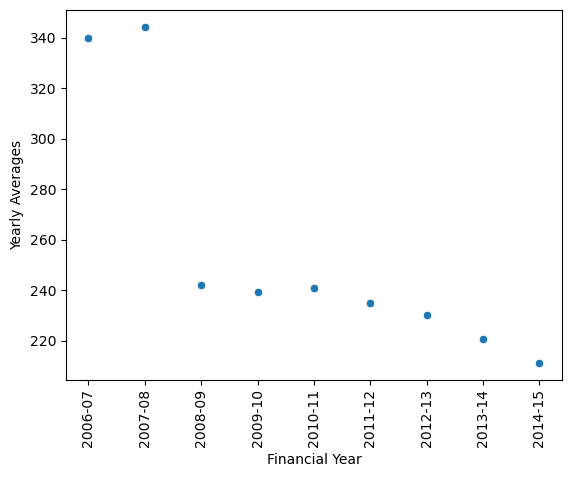

In [257]:
ax = sns.scatterplot(data=Annual_RTD_Consumption , y = 'Yearly Averages', x = 'Financial Year')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

It is also probably more interesting to look at the week number rather than the specific date, so having an index of the week is useful to have.

In [258]:
df['index'] = 0 
for index, row in df.iterrows():
    df['index'][index] = index
df.head()

,Financial Year,Week Number,Week start date,Week end date,RTD Excise Rate in $,Weekly RTD Consumption in Thousands of Liters,Average Weekly Consumption,Weekly RTD Excise Rate in $ Revenue,Spirts Consumption,Weeks Since Excise Increase,Yearly Averages,index
2,2006-07,1.0,2006-07-01,7/7/06,35.98,280.370,297895,10087713,64082,-97,NaN,2
3,2006-07,2.0,2006-07-08,14/07/2006,35.98,277.190,NaN,9973296,70570,-96,NaN,3
4,2006-07,3.0,2006-07-15,21/7/06,35.98,295.785,NaN,10642344,61820,-95,NaN,4
5,2006-07,4.0,2006-07-22,28/07/2006,35.98,338.233,NaN,12169623,71126,-94,NaN,5
6,2006-07,5.0,2006-07-29,4/8/06,NaN,299.626,NaN,0,60231,-93,NaN,6


In [259]:
# Some basic statistics to get an idea of the field.

df['Weekly RTD Consumption in Thousands of Liters'].describe()

count    469.000000
mean     255.797751
std       75.461073
min      135.108000
25%      199.273000
50%      236.909000
75%      298.614000
max      624.725000
Name: Weekly RTD Consumption in Thousands of Liters, dtype: float64

## Exploratory Analysis

The First thing to do is to plot Excise rate against the consumption of RTDs. As we can see that the data comes in two major clumps, one significantly higher than the other.

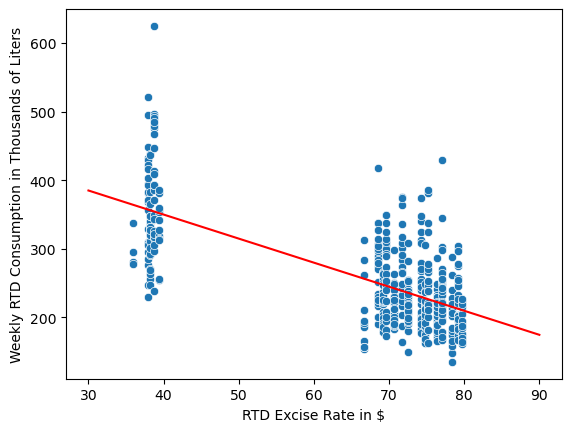

[0.4624454033682147, 55.304899567642735, array([-3.50492047]), 490.04771471660325]
PearsonRResult(statistic=-0.6800333840100902, pvalue=2.275472694866281e-62)


In [260]:
#getting rid of the weeks where the excise changed halfway through the weeks 

df2 = df.dropna(axis=0,subset=['RTD Excise Rate in $'])

# a Plot with our regression line.

x = "RTD Excise Rate in $"
y = 'Weekly RTD Consumption in Thousands of Liters'

sns.scatterplot(data=df2, x = "RTD Excise Rate in $", y = 'Weekly RTD Consumption in Thousands of Liters')
X_plot = np.linspace(30, 90, 100)
Y_plot = do_regression(df2,x,y)[2] *X_plot + do_regression(df2,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()
print(do_regression(df2,x,y))

print(stats.pearsonr(df2["RTD Excise Rate in $"].values, df2['Weekly RTD Consumption in Thousands of Liters'].values))

Given that this data was collected over the course of several years it is worth plotting the data over time. From the plot below we can see that something changed around 2008 so we might want to pursue that further. 

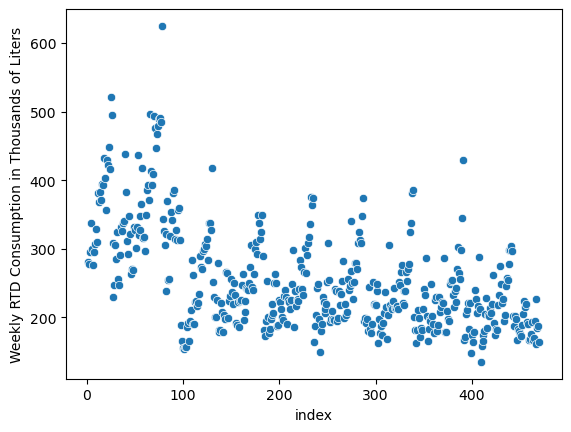

[0.30436272897658234, 62.913484485855534, array([-0.30736385]), 329.4554741475443]


In [261]:
x = 'index'
y = 'Weekly RTD Consumption in Thousands of Liters'

sns.scatterplot(data=df, x= 'index', y= 'Weekly RTD Consumption in Thousands of Liters')

#X_plot = np.linspace(0, 500, 400)
#Y_plot = do_regression(df,x,y)[2] *X_plot + do_regression(df,x,y)[3]
#plt.plot(X_plot, Y_plot, color='r')
plt.show()

print(do_regression(df2,x,y))

Clearly something happend in 2008, looking at the data there was a big change in the excise rate that occurred then, the next cell will zoom in on those weeks to see what is going on. At this level of zoom there doesnt appear to be anything clearly going on, however it might be more apparent if we pull out from the data a bit.

<AxesSubplot: xlabel='index', ylabel='Weekly RTD Consumption in Thousands of Liters'>

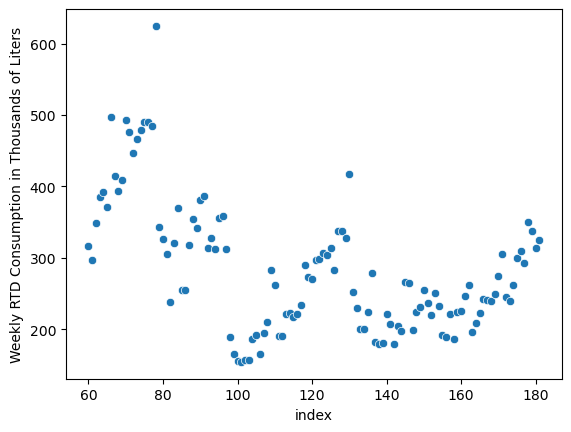

In [262]:
df3 = df.iloc[58:180,:]

x = 'index'
y = 'Weekly RTD Consumption in Thousands of Liters'

sns.scatterplot(data=df3, x= 'index', y= 'Weekly RTD Consumption in Thousands of Liters')

Perhaps it would be more fruitful to look at a wider cross section, and perhaps splitting up the data. The week where the excise rate changed was the 97th week of the data.  

In [263]:
change_week = 91

To test this we can split up the data into before and after the change, below I will plot the data over the whole time period to see what is going on. As we can see from the cell below there is clearly something that is going on however probably need to do a bit more work before we are ready to infer anything more significant. 

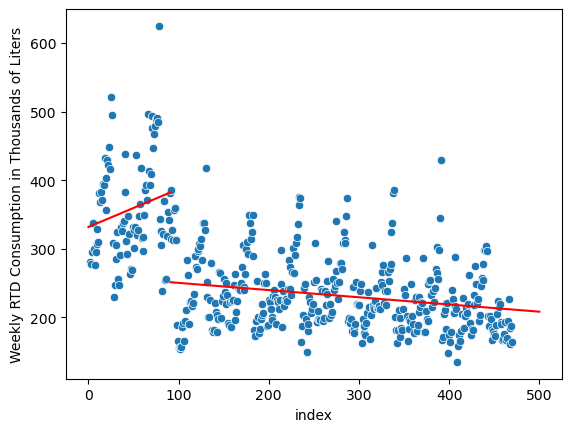

[0.03760218147443406, 73.56012649974406, array([0.5535376]), 331.7855569039656]
[0.050566840657277234, 49.576362855082195, array([-0.10485176]), 260.7569842091915]


In [264]:
# split data with outliers

x = 'index'
y = 'Weekly RTD Consumption in Thousands of Liters'

sns.scatterplot(data=df, x= 'index', y= 'Weekly RTD Consumption in Thousands of Liters')

X_plot = np.linspace(0, change_week, 100)
Y_plot = do_regression(df.iloc[:change_week,:],x,y)[2] *X_plot + do_regression(df.iloc[:change_week,:],x,y)[3]
plt.plot(X_plot, Y_plot, color='r')

X_plot = np.linspace(change_week, 500, 100)
Y_plot = do_regression(df.iloc[change_week:,:],x,y)[2] *X_plot + do_regression(df.iloc[change_week:,:],x,y)[3]
plt.plot(X_plot, Y_plot, color='r')

plt.show()

print(do_regression(df.iloc[:change_week,:],x,y))
print(do_regression(df.iloc[change_week:,:],x,y))


## Regression Discontinuity Analysis

To give a more interesting picture, we can zoom in a little. This will show 91(because that is all the data we have before the change) weeks on either side of the data and show us what is going on. In the cell below I show before and after the change and perform regression discontinuity analysis. As we can see that the level of consumption drops off pretty quickly compared to before the excise increase. 

As we can see before and after the discontinuity there the correlation in time and rtd consumption is broadly similar, after the correlation and before it is not, however the difference in p value is small. From this we can infer there is not that much difference in the consumption trend, what has changed is the mean consumption. as we can see the difference in mean connsumption is both large and significant. 

count     91.000000
mean     357.801824
std       75.398828
min      229.845000
25%      306.702000
50%      340.347000
75%      399.007500
max      624.725000
Name: Weekly RTD Consumption in Thousands of Liters, dtype: float64
count     90.000000
mean     246.986500
std       56.518411
min      154.350000
25%      200.228000
50%      238.223000
75%      289.784750
max      417.135000
Name: Weekly RTD Consumption in Thousands of Liters, dtype: float64
[0.03760218147443406, 73.56012649974406, array([0.5535376]), 386.58577945532727]
[0.04299793970776222, 54.98194898426493, array([0.44860328]), 229.26667059307735]
                                 OLS Regression Results                                
Dep. Variable:     Weeks Since Excise Increase   R-squared:                       0.038
Model:                                     OLS   Adj. R-squared:                  0.027
Method:                          Least Squares   F-statistic:                     3.477
Date:                        

Ttest_indResult(statistic=11.178608895194614, pvalue=2.4136009073170387e-22)

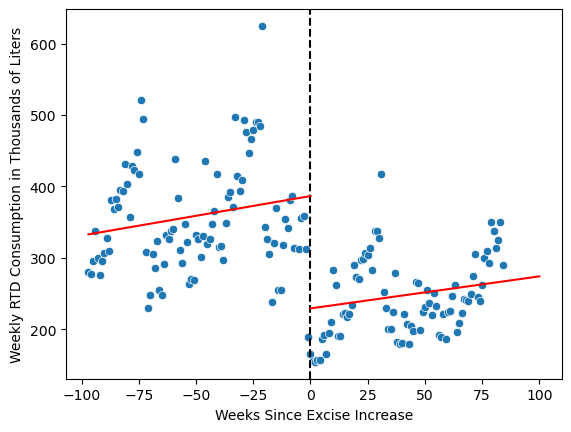

In [265]:
# The relevent data fields

x = 'Weeks Since Excise Increase'
y = 'Weekly RTD Consumption in Thousands of Liters'

# The week that the excise rate was bumped up 

change_week = 91

# the end date to make the data symetric so we are considering the same time period on either side of the change

end_date=182

df4_5 = df.iloc[0:change_week]
df5_5 = df.iloc[change_week+1:end_date]

df6_5 = pd.concat([df4_5,df5_5])

plot = sns.scatterplot(data=df6_5, x= 'Weeks Since Excise Increase', y= 'Weekly RTD Consumption in Thousands of Liters')
plot.axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1,
           color = 'black',
           linestyle = 'dashed') # Top of the plot

X_plot = np.linspace(-97, 0, 100)
Y_plot = do_regression(df4_5,x,y)[2] *X_plot + do_regression(df4_5,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
print(df4_5.iloc[:,5].describe())
X_plot = np.linspace(0, 100, 100)
Y_plot = do_regression(df5_5,x,y)[2] *X_plot + do_regression(df5_5,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
print(df5_5.iloc[:,5].describe())


print(do_regression(df4_5,x,y))
print(do_regression(df5_5,x,y))

y_train = df4_5['Weeks Since Excise Increase']
X_train = df4_5['Weekly RTD Consumption in Thousands of Liters']
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

y_train = df5_5['Weeks Since Excise Increase']
X_train = df5_5['Weekly RTD Consumption in Thousands of Liters']
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

# Performing a pearson correlation test to see if the correlation in time and RTD consumption is the similar and if it is significant.

print(stats.pearsonr(df4_5['Weeks Since Excise Increase'].values ,df4_5['Weekly RTD Consumption in Thousands of Liters']))
print(stats.pearsonr(df5_5['Weeks Since Excise Increase'].values ,df5_5['Weekly RTD Consumption in Thousands of Liters']))

# T test to see if the difference in mean consumption is significant. 

stats.ttest_ind(df4_5['Weekly RTD Consumption in Thousands of Liters'].values ,df5_5['Weekly RTD Consumption in Thousands of Liters'].values )

To be sure that the analysis is not be swayed by outliers, I have repeated the analysis from above with outliers removed. As we can see the results are almost identical, and the data is better supported, with both correlations no longer significant.

count     90.000000
mean     354.836011
std       70.281046
min      229.845000
25%      306.412000
50%      339.290000
75%      394.566000
max      521.137000
Name: Weekly RTD Consumption in Thousands of Liters, dtype: float64
count     91.000000
mean     247.876220
std       56.840777
min      154.350000
25%      200.339000
50%      239.537000
75%      291.194500
max      417.135000
Name: Weekly RTD Consumption in Thousands of Liters, dtype: float64
[0.025626974800265545, 68.98816478496157, array([0.42689718]), 377.18170676151567]
[0.030520205543917656, 55.658301388948345, array([0.37594971]), 233.21418127090305]
                                 OLS Regression Results                                
Dep. Variable:     Weeks Since Excise Increase   R-squared:                       0.026
Model:                                     OLS   Adj. R-squared:                  0.015
Method:                          Least Squares   F-statistic:                     2.314
Date:                    

Ttest_indResult(statistic=11.263491962948278, pvalue=1.373879733258839e-22)

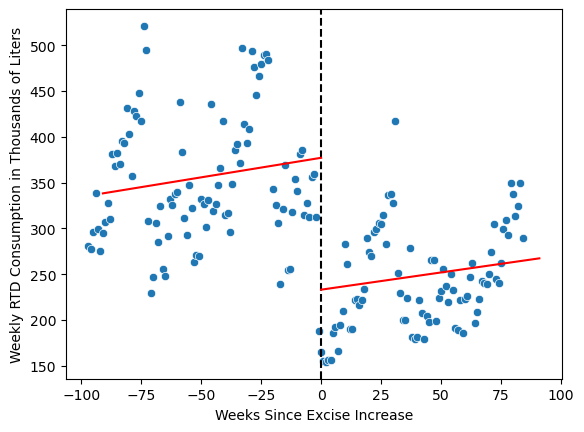

In [266]:
# split data wihtout outliers zoomed in 


x = 'Weeks Since Excise Increase'
y = 'Weekly RTD Consumption in Thousands of Liters'
change_week = 91

end_date=182

z_score =3

df4_5 = df.iloc[0:change_week]
df5_5 = df.iloc[change_week:end_date]
df4 = df4_5[(np.abs(stats.zscore(df4_5['Weekly RTD Consumption in Thousands of Liters'])) < z_score)]
df5 = df5_5[(np.abs(stats.zscore(df5_5['Weekly RTD Consumption in Thousands of Liters'])) < z_score)]

df6 = pd.concat([df4,df5])

plot = sns.scatterplot(data=df6, x= 'Weeks Since Excise Increase', y= 'Weekly RTD Consumption in Thousands of Liters')
plot.axvline(x = 0,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1,
           color = 'black',
           linestyle = 'dashed') # Top of the plot

X_plot = np.linspace(-91, 0, 100)
Y_plot = do_regression(df4,x,y)[2] *X_plot + do_regression(df4,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
print(df4.iloc[:,5].describe())
X_plot = np.linspace(0, 91, 100)
Y_plot = do_regression(df5,x,y)[2] *X_plot + do_regression(df5,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
print(df5.iloc[:,5].describe())


print(do_regression(df4,x,y))
print(do_regression(df5,x,y))

y_train = df4['Weeks Since Excise Increase']
X_train = df4['Weekly RTD Consumption in Thousands of Liters']
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

y_train = df5['Weeks Since Excise Increase']
X_train = df5['Weekly RTD Consumption in Thousands of Liters']
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

print(stats.pearsonr(df4['Weeks Since Excise Increase'].values ,df4['Weekly RTD Consumption in Thousands of Liters']))
print(stats.pearsonr(df5['Weeks Since Excise Increase'].values ,df5['Weekly RTD Consumption in Thousands of Liters']))

stats.ttest_ind(df4['Weekly RTD Consumption in Thousands of Liters'].values ,df5['Weekly RTD Consumption in Thousands of Liters'].values )


### Post Excise Increase Analysis

Considering the time period after the sharp increase (i.e. post 2008) we can look at how inflation indexed rate increases effect the consumption rate of RTDs.

As we can see after the 2008 rate increase there was a steady decline in the consumption of RTDs, while this trend is significant, the correlation is very low. This suggests that the effect is very small, and given that the excise rate strictly increases over time, this could be attributed to may factors that occur over time, including changes in peoples habits. Therefore indexed rate increases are not practically significant.

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

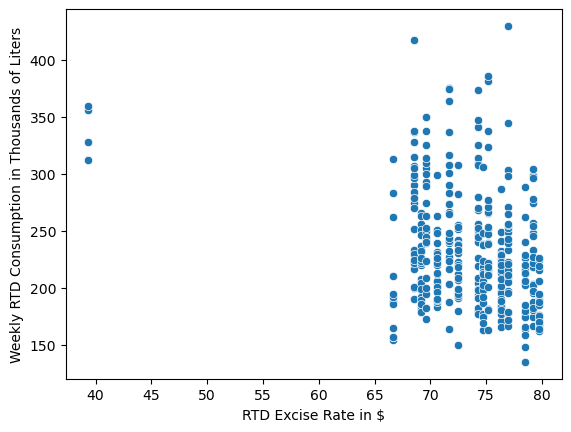

In [267]:
# Only considering the data after the 2008 excise hike

df8 = df.iloc[91:]

x = "RTD Excise Rate in $"
y = 'Weekly RTD Consumption in Thousands of Liters'
sns.scatterplot(data=df8, x = "RTD Excise Rate in $", y = 'Weekly RTD Consumption in Thousands of Liters')
X_plot = np.linspace(65, 80, 100)
Y_plot = do_regression(df8,x,y)[2] *X_plot + do_regression(df8,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()

print(do_regression(df8,x,y))

print(stats.pearsonr(df8["RTD Excise Rate in $"].values ,df8['Weekly RTD Consumption in Thousands of Liters'].values ))

y_train = df8['Weekly RTD Consumption in Thousands of Liters']
X_train = df8["RTD Excise Rate in $"]
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

Performing the same analysis with the outliers removed we find broadly the same results. 

/Users/sufyansaleem/Documents/Data_and_machine_Learning_projects/Data-and-Machine-Learning-Projects/Projects/RTD_Consumption/Useful_function.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{Y} prediction"] = reg.predict((data[X].values).reshape(-1, 1))
/Users/sufyansaleem/Documents/Data_and_machine_Learning_projects/Data-and-Machine-Learning-Projects/Projects/RTD_Consumption/Useful_function.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{Y} prediction"] = reg.predict((data[X].values

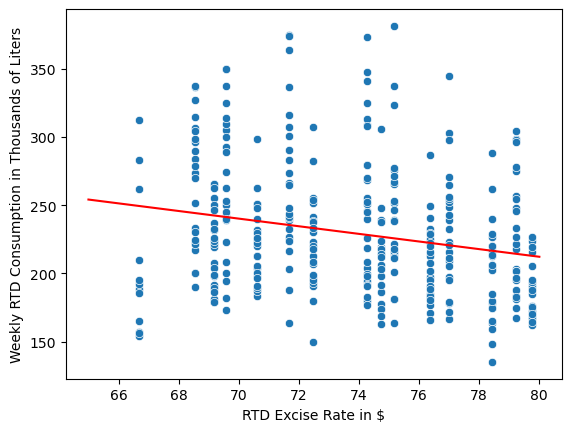

[0.05077138972449291, 46.309545052296286, array([-2.79702056]), 435.9840054116062]
PearsonRResult(statistic=-0.22532507566734009, pvalue=1.7723811426492105e-05)
                                          OLS Regression Results                                         
Dep. Variable:     Weekly RTD Consumption in Thousands of Liters   R-squared:                       0.051
Model:                                                       OLS   Adj. R-squared:                  0.048
Method:                                            Least Squares   F-statistic:                     18.93
Date:                                           Mon, 12 Jun 2023   Prob (F-statistic):           1.77e-05
Time:                                                   12:12:37   Log-Likelihood:                -1870.5
No. Observations:                                            356   AIC:                             3745.
Df Residuals:                                                354   BIC:                          

/Users/sufyansaleem/Documents/Data_and_machine_Learning_projects/Data-and-Machine-Learning-Projects/Projects/RTD_Consumption/Useful_function.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f"{Y} prediction"] = reg.predict((data[X].values).reshape(-1, 1))


In [ ]:
df8_5 = df.iloc[91:]
z_score = 3
df8 = df8_5[(np.abs(stats.zscore(df8_5['Weekly RTD Consumption in Thousands of Liters'])) < z_score)]


x = "RTD Excise Rate in $"
y = 'Weekly RTD Consumption in Thousands of Liters'
sns.scatterplot(data=df8, x = "RTD Excise Rate in $", y = 'Weekly RTD Consumption in Thousands of Liters')
X_plot = np.linspace(65, 80, 100)
Y_plot = do_regression(df8,x,y)[2] *X_plot + do_regression(df8,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()

print(do_regression(df8,x,y))

print(stats.pearsonr(df8["RTD Excise Rate in $"].values ,df8['Weekly RTD Consumption in Thousands of Liters'].values ))

y_train = df8['Weekly RTD Consumption in Thousands of Liters']
X_train = df8["RTD Excise Rate in $"]
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())


### Revenue Analysis

Although it is beyond the scope of this question we can also look at the effect of excise rate increases on revenue, just for fun. 

In [ ]:
df2['Weekly RTD Excise Rate in $ Revenue'] = pd.to_numeric(df2['Weekly RTD Excise Rate in $ Revenue'])

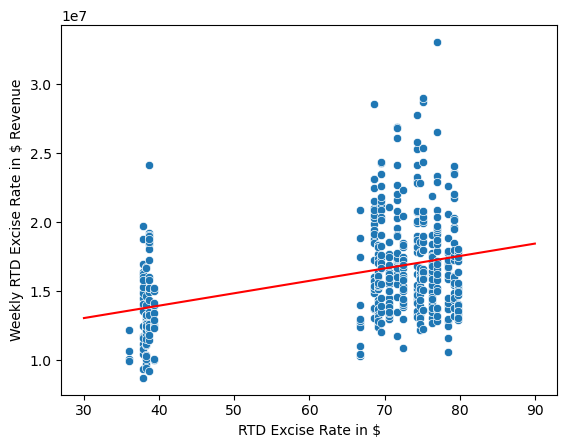

In [ ]:
x = "RTD Excise Rate in $"
y = 'Weekly RTD Excise Rate in $ Revenue'
sns.scatterplot(data=df2, x = "RTD Excise Rate in $", y = 'Weekly RTD Excise Rate in $ Revenue')
X_plot = np.linspace(30, 90, 100)
Y_plot = do_regression(df2,x,y)[2] *X_plot + do_regression(df2,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()

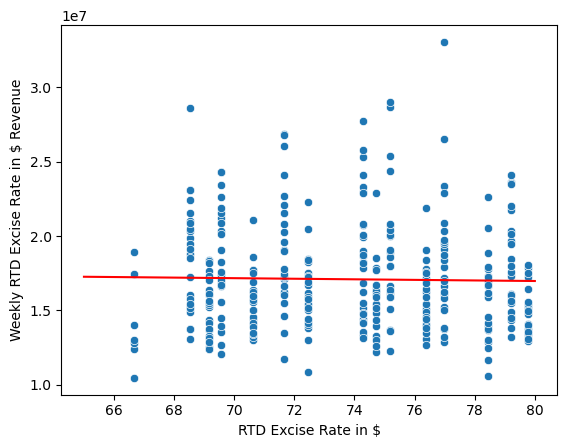

[0.0004083330112197858, 3542568.3177900123, array([-19110.76683064]), 18497010.4264515]


In [ ]:
df7 = df2.iloc[97:,:]

x = "RTD Excise Rate in $"
y = 'Weekly RTD Excise Rate in $ Revenue'
sns.scatterplot(data=df7, x = "RTD Excise Rate in $", y = 'Weekly RTD Excise Rate in $ Revenue')
X_plot = np.linspace(65, 80, 100)
Y_plot = do_regression(df7,x,y)[2] *X_plot + do_regression(df7,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()

print(do_regression(df7,x,y))

In [ ]:
x = "RTD Excise Rate in $"
y = 'Weekly RTD Excise Rate in $ Revenue'

print(do_regression(df,x,y))

[0.1256973877773827, 3472051.432756991, array([89952.65867137]), 10351410.458486557]


In [ ]:
df1 = df.copy(deep=True)
df1 = df1.dropna(axis=0,subset=['Average Weekly Consumption'])
df1.head()
df1['Average Weekly Consumption'] = pd.to_numeric(df1['Average Weekly Consumption'])

[0.6882330958940022, 30080.02693320975, array([-2830.90727327]), 440002.67969308177]


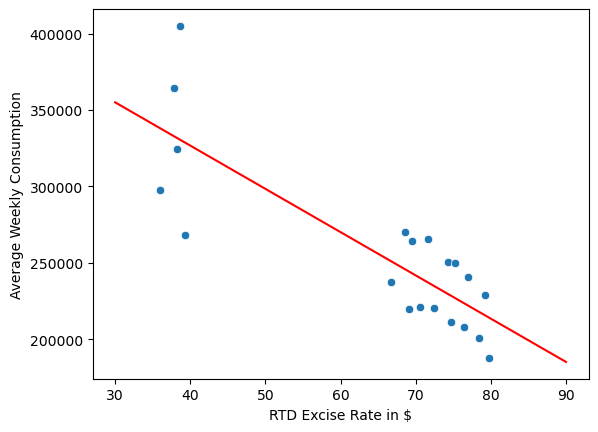

PearsonRResult(statistic=-0.8295981532609641, pvalue=6.088306146849989e-06)
                                OLS Regression Results                                
Dep. Variable:     Average Weekly Consumption   R-squared:                       0.688
Model:                                    OLS   Adj. R-squared:                  0.671
Method:                         Least Squares   F-statistic:                     39.74
Date:                        Mon, 12 Jun 2023   Prob (F-statistic):           6.09e-06
Time:                                12:12:37   Log-Likelihood:                -234.61
No. Observations:                          20   AIC:                             473.2
Df Residuals:                              18   BIC:                             475.2
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                           coef    std err          t 

In [ ]:
x = "RTD Excise Rate in $"
y = 'Average Weekly Consumption'

print(do_regression(df1,x,y))
sns.scatterplot(data=df1, x = "RTD Excise Rate in $", y = 'Average Weekly Consumption')
X_plot = np.linspace(30, 90, 100)
Y_plot = do_regression(df1,x,y)[2] *X_plot + do_regression(df1,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()

print(stats.pearsonr(df1["RTD Excise Rate in $"].values ,df1['Average Weekly Consumption'].values ))

y_train = df1['Average Weekly Consumption']
X_train = df1["RTD Excise Rate in $"]
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

In [ ]:
# working out the average revenue per week. 

df1['Average Weekly revenue'] = df1['RTD Excise Rate in $'] * df1['Average Weekly Consumption']


[0.5490077300810026, 1672577.061839422, array([116892.18295964]), 8349770.729707003]


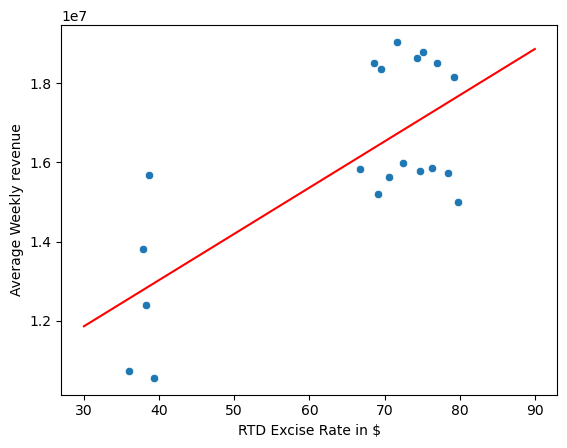

In [ ]:
x = "RTD Excise Rate in $"
y = 'Average Weekly revenue'

print(do_regression(df1,x,y))

sns.scatterplot(data=df1, x = "RTD Excise Rate in $", y = 'Average Weekly revenue')
X_plot = np.linspace(30, 90, 100)
Y_plot = do_regression(df1,x,y)[2] *X_plot + do_regression(df1,x,y)[3]
plt.plot(X_plot, Y_plot, color='r')
plt.show()